In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import sklearn.model_selection as ms
from sklearn.naive_bayes import *
from sklearn.multiclass import *
from sklearn.svm import *
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import re
import os
%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

from sklearn.metrics import *
from sklearn.calibration import *
def performance_metrics(y_true,y_score,y_pred,pos):
    #f1 score
    f1 = f1_score(y_true,y_pred,average="macro",pos_label=pos)
    print('F1 score: {0:0.2f}'.format(f1))
    
    #precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_true,y_score,pos_label=pos)
    
    
    print('Average precision: {0:0.2f}'.format(np.mean(precision)))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
              np.mean(precision)))
    


    #ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true,y_score,pos_label=pos)
    auc = np.trapz(tpr,fpr)
    print('ROC curve AUC= {0:0.2f}'.format(auc))
    plt.figure()
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve AUC= {0:0.2f}'.format(
              auc))

    
    #accuracy
    accuracy = accuracy_score(y_true,y_pred)
    print('Accuracy: {0:0.2f}'.format(accuracy))
    
    #brier score
    brier = brier_score_loss(y_true,y_score)
    print('Brier score: {0:0.2f}'.format(brier))

In [4]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [5]:
all_df = pd.read_csv('data/10k_sentiment.csv')

In [6]:
all_df

,text,score
0,@VirginAmerica happy to spend the day together...,1
1,"I also didn't like the ""on"" button, it felt li...",0
2,"Redundant, everlasting shots, useless shots, u...",0
3,thunderstruck: much of this book was tedious. ...,0
4,@SouthwestAir JUST GAVE ME TICKETS TO SEE @Ima...,1
...,...,...
9995,@united have an employee at the gate 15min bef...,0
9996,@united was forced to book a flight on a diff...,0
9997,The first murder scene is one of the best murd...,1
9998,This is a classic stinker with a big named cas...,0


In [7]:
ct = CleanText()
sr_clean = ct.fit_transform(all_df.text)
sr_clean.sample(5)

2508    agree frequent tweeter discount could fly see ...
4915    hands made controller far comfortable controll...
1722    damn seen movie least times still get bored wa...
8819    one ten stars br br gets holy mother mary god ...
9268    get anyone phone day flight rebooked missing c...
Name: text, dtype: object

In [8]:
all_df.text = sr_clean

In [9]:
all_df.text[45]

'seen cheesy kung fu fight films living taiwan come lieu sitcoms america seen movies make fun film belongs sad category fight films try hard awful actors awful props awful music taken seriously seriously felt pity person composed music movie sad must composer churn crap like thought titled generic ninja fight scene op variations bad guy pointing gun girl head backed corner daring flight helicopter fight scenes credits rolled actually tears laughing special effects proof enough low budget fact two three crew members presumably locals although good much needed phillipino economy probably done solely save money ever done anything since series movies rented equipment despite making sequels movie pretty funny thing really going though not music left half expecting animated sargeant slaughter joe pop ending suppose would spoiler really plot spoil american ninja drops girl jackson arms takes mask wanted see jump roof jackson drop girl catch br br think would perfect punchline joke movie'

In [10]:
train_set,test_set = ms.train_test_split(all_df)

In [11]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

def perform(classifiers, vectorizers, train_set, test_set):
    
    
    for vectorizer in vectorizers:
        
        vectorize_text = vectorizer.fit_transform(train_set.text)
        vectorize_text = vectorize_text.toarray()
        
        vectorize_test_text = vectorizer.transform(test_set.text)
        vectorize_test_text = vectorize_test_text.toarray()
        
        for classifier in classifiers:
            string = ''
            string += classifier.__class__.__name__ + ' with ' + vectorizer.__class__.__name__
            
            # train
            y = train_set.score
            classifier.fit(vectorize_text, y)

            # score
            score = classifier.score(vectorize_test_text, test_set.score)
            string += '. Has accuracy: ' + str(score)
            print(string)
            class_names = [0,1]
            y_true = test_set.score
            y_score = classifier.predict_proba(vectorize_test_text)
            y_score = [i[0] for i in y_score]
            y_predict = classifier.predict(vectorize_test_text)
            plt.figure()
            performance_metrics(y_true,y_score,y_predict,class_names[0])
            cnf_matrix = confusion_matrix(y_true,y_predict)
            
            
            plot_confusion_matrix(classifier,vectorize_test_text,y_true,normalize='true')
            plt.show()
    return vectorizer,classifier

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


BernoulliNB with TfidfVectorizer. Has accuracy: 0.84


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


F1 score: 0.84
Average precision: 0.79
ROC curve AUC= 0.90
Accuracy: 0.84
Brier score: 0.71


<Figure size 432x288 with 0 Axes>

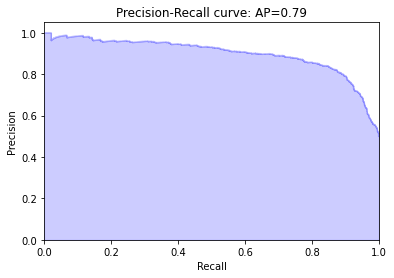

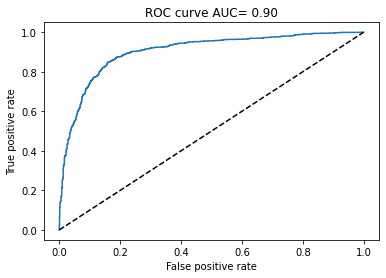

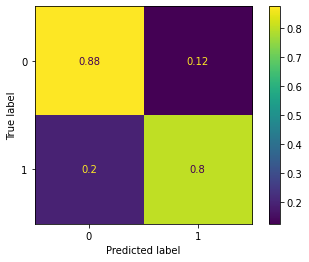

In [13]:
vectorizer,classifier = perform([BernoulliNB()],
                                [TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True)],
       train_set,
       test_set)

In [41]:
sentence = pd.Series(["the delivery was not on time!"])

In [42]:
sentence = ct.transform(sentence)
sentence

0    delivery not time
dtype: object

In [43]:
transformed = vectorizer.transform(sentence)
transformed = transformed.toarray()
classifier.predict_proba(transformed)

array([[0.47342102, 0.52657898]])

## 16 December 2020

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn.model_selection as ms

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding,  Dropout,  SpatialDropout1D, LSTM
from tensorflow.keras import backend as K

In [45]:
all_df = pd.read_csv('data/10k_sentiment.csv')

In [46]:
all_df.head()

,text,score
0,@VirginAmerica happy to spend the day together...,1
1,"I also didn't like the ""on"" button, it felt li...",0
2,"Redundant, everlasting shots, useless shots, u...",0
3,thunderstruck: much of this book was tedious. ...,0
4,@SouthwestAir JUST GAVE ME TICKETS TO SEE @Ima...,1


In [49]:
y = all_df[['score']]

#train-test split
X_train, X_test, y_train, y_test = ms.train_test_split(all_df.text, y, test_size=0.25, random_state=42)
print('splitted')

#clean
ct = CleanText()
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

print('cleaned')


#tokenization
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train) #sadece train ile yap

X_train = tokenizer.texts_to_sequences(X_train) #train ve test için ayrı ayrı yap
X_train = pad_sequences(X_train,maxlen=217) #train ve test için ayrı ayrı yap

X_test = tokenizer.texts_to_sequences(X_test) #train ve test için ayrı ayrı yap
X_test = pad_sequences(X_test,maxlen=217) #train ve test için ayrı ayrı yap

print('tokenized')

#create the LSTM model
embed_dim = 32
lstm_out = 1

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train.shape[1],activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

# fit model
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 2, batch_size=batch_size, verbose = 1)




splitted
cleaned
tokenized
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 217, 32)           320000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 217, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 320,138
Trainable params: 320,138
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
235/235 [==============================] - 93s 396ms/step - loss: 0.6671 - accuracy: 0.6951 - val_loss: 0.6258 - val_accuracy: 0.7476
Epoch 2/2
235/235 [==============================] - 80s 341ms/step - 

In [50]:
model.evaluate(X_test,y_test)

79/79 [==============================] - 5s 59ms/step - loss: 0.5510 - accuracy: 0.8044


[0.5510444641113281, 0.8044000267982483]

In [51]:
model.predict(X_test)

array([[0.32988667],
       [0.33973306],
       [0.61606383],
       ...,
       [0.49307716],
       [0.47454116],
       [0.4491946 ]], dtype=float32)

In [54]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [55]:
X_test[0].shape

(217,)

In [56]:
from sklearn.preprocessing import LabelBinarizer

In [57]:
lb = LabelBinarizer()

In [65]:
lb.fit_transform([1,0,4,0,3,0,1,1,2,1,0,1,1,2,1,0])

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [60]:
all_df.score

0       1
1       0
2       0
3       0
4       1
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: score, Length: 10000, dtype: int64

In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    #note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
    #from vaderSentiment import SentimentIntensityAnalyzer

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.------------------------ {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.------------------------ {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!---------------------- {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!--------- {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.----------------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'co